In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score

import scipy.cluster.hierarchy as sch

In [2]:
!pip install umap-learn
import umap

In [3]:
from google.colab import files
uploaded = files.upload()

Saving archive.zip to archive.zip
Saving online+retail+ii.zip to online+retail+ii.zip


In [10]:
import zipfile

# Unzip mall customers dataset
with zipfile.ZipFile("archive.zip", 'r') as zip_ref:
    zip_ref.extractall("mall_data")

# Unzip online retail dataset
with zipfile.ZipFile("online+retail+ii.zip", 'r') as zip_ref:
    zip_ref.extractall("retail_data")

import os

print("Mall folder:", os.listdir("mall_data"))
print("Retail folder:", os.listdir("retail_data"))

Mall folder: ['Mall_Customers.csv']
Retail folder: ['online_retail_II.xlsx']


In [12]:
import pandas as pd

mall_df = pd.read_csv("mall_data/Mall_Customers.csv")
retail_df = pd.read_excel("retail_data/online_retail_II.xlsx")

# If it's split into 2 parts:
# retail_1 = pd.read_excel("online_retail_II_2010-2011.xlsx")
# retail_2 = pd.read_excel("online_retail_II_2009-2010.xlsx")
# retail_df = pd.concat([retail_1, retail_2])

In [13]:
mall_df = mall_df.rename(columns={
    "Genre": "Gender",
    "Annual Income (k$)": "AnnualIncome",
    "Spending Score (1-100)": "SpendingScore"
})
mall_df.head()

,CustomerID,Gender,Age,AnnualIncome,SpendingScore
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [14]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

df_m = mall_df.copy()

# Encode Gender
le = LabelEncoder()
df_m["GenderEncoded"] = le.fit_transform(df_m["Gender"])

features = ["Age", "AnnualIncome", "SpendingScore", "GenderEncoded"]

X_mall = df_m[features].copy()

# Scaling
scaler = StandardScaler()
X_mall_scaled = scaler.fit_transform(X_mall)

In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X_mall_pca = pca.fit_transform(X_mall_scaled)

reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
X_mall_umap = reducer.fit_transform(X_mall_scaled)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


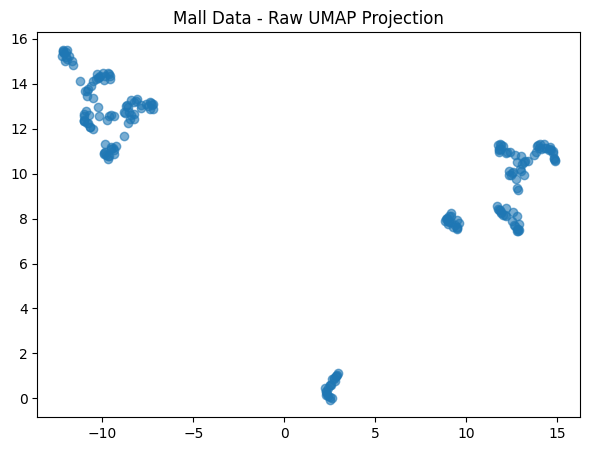

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7,5))
plt.scatter(X_mall_umap[:, 0], X_mall_umap[:, 1], alpha=0.6)
plt.title("Mall Data - Raw UMAP Projection")
plt.show()

In [17]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

scores = {}
for k in range(2, 11):
    labels = KMeans(n_clusters=k, n_init=10, random_state=42).fit_predict(X_mall_scaled)
    scores[k] = silhouette_score(X_mall_scaled, labels)

scores

{2: np.float64(0.2518152915788437),
 3: np.float64(0.25951265087431563),
 4: np.float64(0.2983972818544038),
 5: np.float64(0.3040600988258827),
 6: np.float64(0.33107393337175933),
 7: np.float64(0.3573771582429211),
 8: np.float64(0.3879927454351689),
 9: np.float64(0.40309165116555223),
 10: np.float64(0.42076374869477745)}

In [18]:
optimal_k = max(scores, key=scores.get)
optimal_k

10

In [19]:
kmeans = KMeans(n_clusters=optimal_k, n_init=10, random_state=42)
mall_labels = kmeans.fit_predict(X_mall_scaled)

df_m["Cluster"] = mall_labels

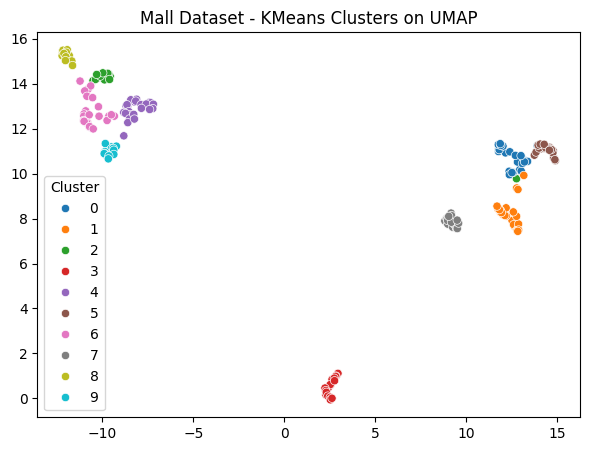

In [20]:
plt.figure(figsize=(7,5))
sns.scatterplot(x=X_mall_umap[:,0], y=X_mall_umap[:,1],
                hue=df_m["Cluster"], palette="tab10")
plt.title("Mall Dataset - KMeans Clusters on UMAP")
plt.show()

In [25]:
cluster_profile = df_m.groupby("Cluster")[["Age", "AnnualIncome", "SpendingScore"]].mean()
cluster_profile

,Age,AnnualIncome,SpendingScore
Cluster,,,
0,58.846154,48.692308,39.846154
1,25.250000,41.250000,60.916667
2,41.214286,26.071429,20.142857
3,32.190476,86.047619,81.666667
4,54.153846,54.230769,48.961538
5,38.473684,85.894737,14.210526
6,27.960000,57.360000,47.120000
7,33.277778,87.111111,82.666667
8,25.461538,25.692308,80.538462


In [27]:
persona_map = {
    0: "Young Luxury Shopper",
    1: "High Income Low Spending",
    2: "Budget Conscious",
    3: "Average Income Average Spend",
    4: "Young High Spenders",
    5: "Older High Spenders",
    6: "Loyal Moderate Spenders",
    7: "High Income Very High Spend",
    8: "Low Income Low Spend",
    9: "Older Low Spending"
}

df_m["Persona"] = df_m["Cluster"].map(persona_map)
df_m.head()

,CustomerID,Gender,Age,AnnualIncome,SpendingScore,GenderEncoded,Cluster,Persona
0,1,Male,19,15,39,1,1,High Income Low Spending
1,2,Male,21,15,81,1,1,High Income Low Spending
2,3,Female,20,16,6,0,2,Budget Conscious
3,4,Female,23,16,77,0,8,Low Income Low Spend
4,5,Female,31,17,40,0,2,Budget Conscious


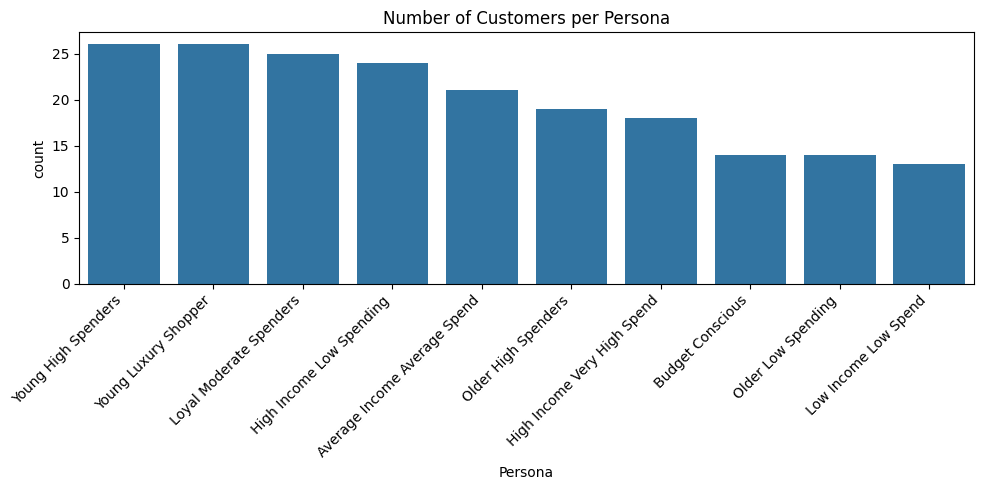

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.countplot(data=df_m, x="Persona", order=df_m["Persona"].value_counts().index)
plt.xticks(rotation=45, ha="right")
plt.title("Number of Customers per Persona")
plt.tight_layout()
plt.show()

In [29]:
persona_stats = df_m.groupby("Persona")[["Age","AnnualIncome","SpendingScore"]].mean()
persona_stats

,Age,AnnualIncome,SpendingScore
Persona,,,
Average Income Average Spend,32.190476,86.047619,81.666667
Budget Conscious,41.214286,26.071429,20.142857
High Income Low Spending,25.250000,41.250000,60.916667
High Income Very High Spend,33.277778,87.111111,82.666667
Low Income Low Spend,25.461538,25.692308,80.538462
Loyal Moderate Spenders,27.960000,57.360000,47.120000
Older High Spenders,38.473684,85.894737,14.210526
Older Low Spending,43.785714,93.285714,20.642857
Young High Spenders,54.153846,54.230769,48.961538


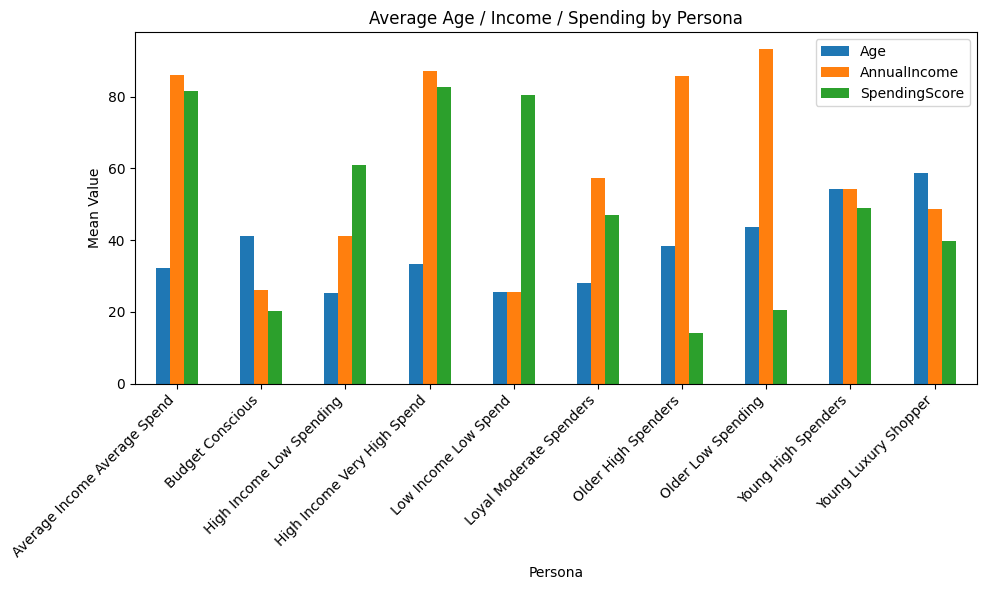

In [30]:
persona_stats.plot(kind="bar", figsize=(10,6))
plt.title("Average Age / Income / Spending by Persona")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Mean Value")
plt.tight_layout()
plt.show()

In [31]:
reducer = umap.UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    random_state=42
)

X_mall_umap = reducer.fit_transform(X_mall_scaled)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


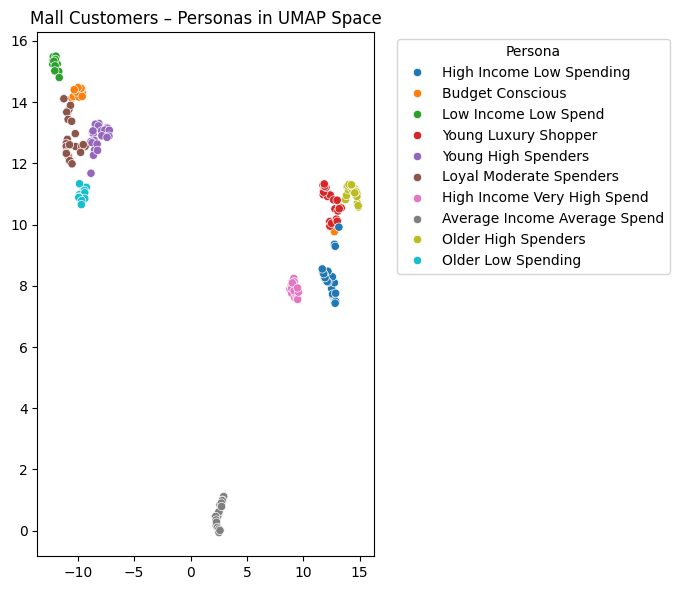

In [33]:
plt.figure(figsize=(7,6))
sns.scatterplot(
    x=X_mall_umap[:,0],
    y=X_mall_umap[:,1],
    hue=df_m["Persona"],
    palette="tab10"
)
plt.title("Mall Customers – Personas in UMAP Space")
plt.legend(title="Persona", bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.show()

In [34]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

sil = silhouette_score(X_mall_scaled, df_m["Cluster"])
db  = davies_bouldin_score(X_mall_scaled, df_m["Cluster"])

print("Silhouette Score:", sil)
print("Davies-Bouldin Score:", db)

Silhouette Score: 0.42076374869477745
Davies-Bouldin Score: 0.8331029646644399


In [35]:
df_m.to_csv("mall_customer_segments.csv", index=False)

from google.colab import files
files.download("mall_customer_segments.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [38]:
import zipfile, os

with zipfile.ZipFile("online+retail+ii.zip", "r") as z:
    z.extractall("retail_data")

os.listdir("retail_data")

['online_retail_II.xlsx']

In [39]:
import pandas as pd

retail_df = pd.read_excel("retail_data/online_retail_II.xlsx")
retail_df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [40]:
retail_df = retail_df[~retail_df["Invoice"].astype(str).str.startswith("C")]

# Drop rows without customer id
retail_df = retail_df.dropna(subset=["Customer ID"])

# Total amount
retail_df["TotalAmount"] = retail_df["Price"] * retail_df["Quantity"]

In [41]:
NOW = retail_df["InvoiceDate"].max() + pd.Timedelta(days=1)

rfm = retail_df.groupby("Customer ID").agg({
    "InvoiceDate": lambda x: (NOW - x.max()).days,
    "Invoice": "count",
    "TotalAmount": "sum"
}).reset_index()

rfm.columns = ["CustomerID", "Recency", "Frequency", "Monetary"]
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,165,33,372.86
1,12347.0,3,71,1323.32
2,12348.0,74,20,222.16
3,12349.0,43,102,2671.14
4,12351.0,11,21,300.93


In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

scaler = StandardScaler()
X_rfm_scaled = scaler.fit_transform(rfm[["Recency","Frequency","Monetary"]])

k_rfm = 10

kmeans_rfm = KMeans(n_clusters=k_rfm, n_init=10, random_state=42)
rfm["Cluster"] = kmeans_rfm.fit_predict(X_rfm_scaled)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


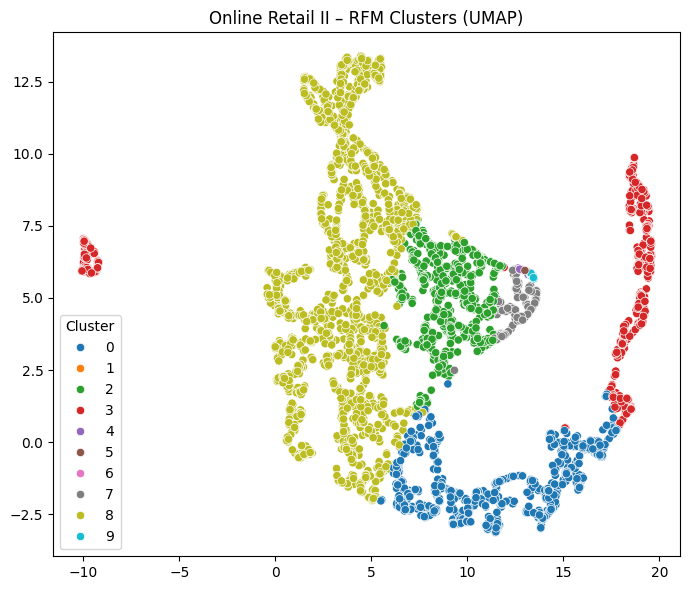

In [43]:
reducer_rfm = umap.UMAP(n_components=2, random_state=42)
X_rfm_umap = reducer_rfm.fit_transform(X_rfm_scaled)

plt.figure(figsize=(7,6))
sns.scatterplot(
    x=X_rfm_umap[:,0],
    y=X_rfm_umap[:,1],
    hue=rfm["Cluster"],
    palette="tab10"
)
plt.title("Online Retail II – RFM Clusters (UMAP)")
plt.tight_layout()
plt.show()

In [44]:
rfm_profile = rfm.groupby("Cluster")[["Recency","Frequency","Monetary"]].mean()
rfm_profile

,Recency,Frequency,Monetary
Cluster,,,
0,164.209763,39.327177,768.234670
1,8.500000,2211.000000,222481.620000
2,25.266003,195.722617,3635.845582
3,295.915596,24.302752,541.668943
4,7.666667,402.333333,64632.310000
5,1.000000,627.000000,349164.350000
6,1.333333,4826.333333,66914.826667
7,16.853333,511.026667,8080.008153
8,41.107917,46.336475,929.888998


In [45]:
persona_map_retail = {
    6: "Champion / VIP Royal Customers",
    5: "Premium VIP Spenders",
    1: "Loyal High Spenders",
    4: "Recent Active Buyers",
    7: "Growing Loyalists",
    9: "Potential Loyalists",
    2: "Regular Budget Buyers",
    0: "Churn Risk Customers",
    8: "Low Value Customers",
    3: "Lost Customers"
}

rfm["Persona"] = rfm["Cluster"].map(persona_map_retail)
rfm.head()

,CustomerID,Recency,Frequency,Monetary,Cluster,Persona
0,12346.0,165,33,372.86,0,Churn Risk Customers
1,12347.0,3,71,1323.32,8,Low Value Customers
2,12348.0,74,20,222.16,8,Low Value Customers
3,12349.0,43,102,2671.14,8,Low Value Customers
4,12351.0,11,21,300.93,8,Low Value Customers


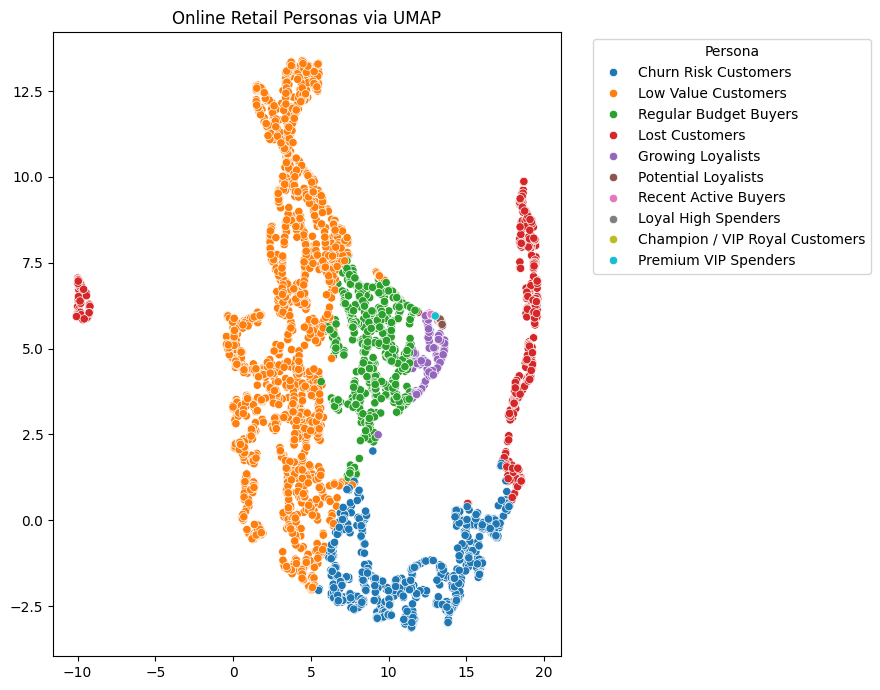

In [46]:
plt.figure(figsize=(9,7))
sns.scatterplot(
    x=X_rfm_umap[:,0],
    y=X_rfm_umap[:,1],
    hue=rfm["Persona"],
    palette="tab10"
)
plt.title("Online Retail Personas via UMAP")
plt.legend(title="Persona", bbox_to_anchor=(1.05,1))
plt.tight_layout()
plt.show()

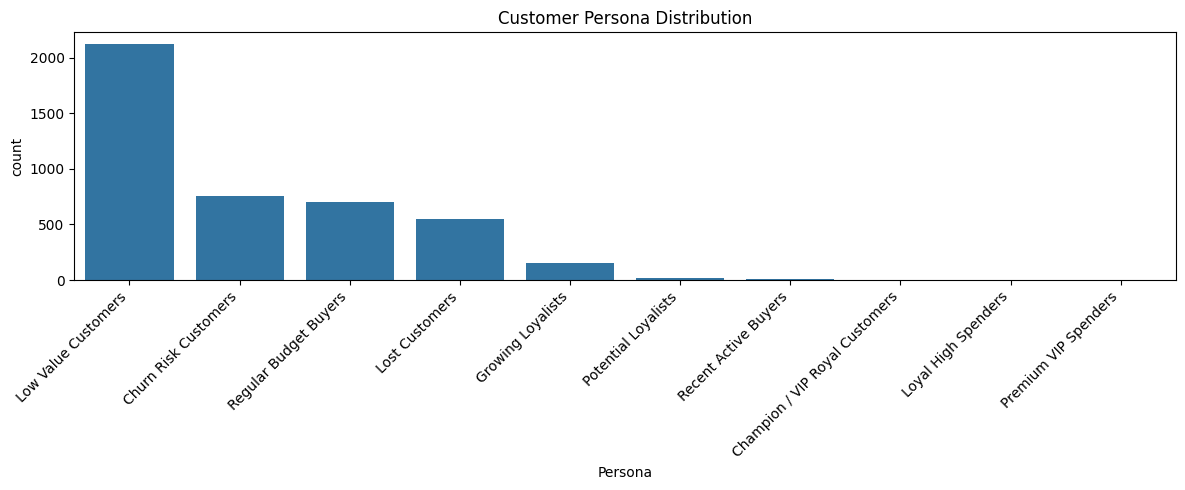

In [48]:
plt.figure(figsize=(12,5))
sns.countplot(
    data=rfm,
    x="Persona",
    order=rfm["Persona"].value_counts().index
)
plt.xticks(rotation=45, ha="right")
plt.title("Customer Persona Distribution")
plt.tight_layout()
plt.show()

In [49]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

print("Silhouette Score:", silhouette_score(X_rfm_scaled, rfm["Cluster"]))
print("Davies-Bouldin Score:", davies_bouldin_score(X_rfm_scaled, rfm["Cluster"]))

Silhouette Score: 0.45251271847353713
Davies-Bouldin Score: 0.6859854715622797


In [50]:
rfm.to_csv("online_retail_customer_segments.csv", index=False)

from google.colab import files
files.download("online_retail_customer_segments.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [51]:
# Attach UMAP coordinates to dataframes
df_m["UMAP1"] = X_mall_umap[:, 0]
df_m["UMAP2"] = X_mall_umap[:, 1]

rfm["UMAP1"] = X_rfm_umap[:, 0]
rfm["UMAP2"] = X_rfm_umap[:, 1]

In [52]:
!pip install gradio -q

import gradio as gr
import matplotlib.pyplot as plt
import seaborn as sns

In [55]:
def mall_lookup(customer_id):
    try:
        customer_id = int(customer_id)
    except:
        return "Please enter a valid integer CustomerID", None

    row = df_m[df_m["CustomerID"] == customer_id]

    if row.empty:
        return f"No customer found with ID {customer_id}", None

    persona = row["Persona"].iloc[0]
    short_df = row[["CustomerID", "Gender", "Age", "AnnualIncome",
                    "SpendingScore", "Cluster", "Persona"]]
    return f"Persona: {persona}", short_df

In [56]:
def retail_lookup(customer_id):
    try:
        customer_id = float(customer_id)
    except:
        return "Please enter a valid numeric CustomerID", None

    row = rfm[rfm["CustomerID"] == customer_id]

    if row.empty:
        return f"No customer found with ID {customer_id}", None

    persona = row["Persona"].iloc[0]
    short_df = row[["CustomerID", "Recency", "Frequency",
                    "Monetary", "Cluster", "Persona"]]
    return f"Persona: {persona}", short_df

In [57]:
def plot_umap(dataset):
    fig, ax = plt.subplots(figsize=(7, 6))

    if dataset == "Mall Customers":
        sns.scatterplot(
            data=df_m,
            x="UMAP1", y="UMAP2",
            hue="Persona",
            palette="tab10",
            ax=ax,
            s=20
        )
        ax.set_title("Mall Customers – UMAP by Persona")
    else:
        sns.scatterplot(
            data=rfm,
            x="UMAP1", y="UMAP2",
            hue="Persona",
            palette="tab10",
            ax=ax,
            s=20
        )
        ax.set_title("Online Retail – UMAP by Persona")

    ax.legend(title="Persona", bbox_to_anchor=(1.05, 1), loc="upper left")
    fig.tight_layout()
    return fig

In [58]:
with gr.Blocks() as demo:
    gr.Markdown("## 🛍️ Customer Segmentation Dashboard (Mall + Online Retail)")

    with gr.Tab("Mall Customers"):
        gr.Markdown("### Look up a mall customer and view their persona")

        mall_id_in = gr.Number(label="CustomerID", value=1, precision=0)
        mall_info_out = gr.Textbox(label="Persona & Message")
        mall_df_out = gr.Dataframe(label="Customer Details", interactive=False)

        mall_btn = gr.Button("Lookup Customer")
        mall_btn.click(
            mall_lookup,
            inputs=mall_id_in,
            outputs=[mall_info_out, mall_df_out]
        )

        gr.Markdown("### UMAP visualization of mall personas")
        mall_plot_btn = gr.Button("Show UMAP")
        mall_plot_out = gr.Plot()
        mall_plot_btn.click(
            lambda: plot_umap("Mall Customers"),
            inputs=None,
            outputs=mall_plot_out
        )

    with gr.Tab("Online Retail II"):
        gr.Markdown("### Look up a retail customer and view their persona")

        retail_id_in = gr.Number(label="CustomerID", value=12347)
        retail_info_out = gr.Textbox(label="Persona & Message")
        retail_df_out = gr.Dataframe(label="Customer RFM & Segment", interactive=False)

        retail_btn = gr.Button("Lookup Customer")
        retail_btn.click(
            retail_lookup,
            inputs=retail_id_in,
            outputs=[retail_info_out, retail_df_out]
        )

        gr.Markdown("### UMAP visualization of retail personas")
        retail_plot_btn = gr.Button("Show UMAP")
        retail_plot_out = gr.Plot()
        retail_plot_btn.click(
            lambda: plot_umap("Online Retail II"),
            inputs=None,
            outputs=retail_plot_out
        )

demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://0c77a4778f892e3d1c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
